In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-21 14-41-35.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-21 14-41-35_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_01-test-01.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1753627981.366459 2482171 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753627981.374056 2482742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753627981.379010 2482742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1753627982.470769 2482752 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 12842
Frames with at least 1 hand detected: 11039
Detection rate: 85.96%


In [1]:
df = pd.read_csv("hand_landmarks_01-test-02.csv")

print("Shape:", df.shape)
df

Shape: (367290, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.00,Left,0,NaN,NaN,NaN,0
1,0,0.00,Left,1,NaN,NaN,NaN,0
2,0,0.00,Left,2,NaN,NaN,NaN,0
3,0,0.00,Left,3,NaN,NaN,NaN,0
4,0,0.00,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
367285,12841,214.05,Right,16,NaN,NaN,NaN,0
367286,12841,214.05,Right,17,NaN,NaN,NaN,0
367287,12841,214.05,Right,18,NaN,NaN,NaN,0
367288,12841,214.05,Right,19,NaN,NaN,NaN,0


In [2]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,25,0.416667,Left,1,0.575369,0.538491,0.505117,0.474572,0.448323,0.522242,...,-0.025678,-0.027330,-0.018100,-0.023269,-0.026682,-0.028075,-0.022507,-0.024372,-0.022837,-0.020855
1,26,0.433333,Left,1,0.579894,0.540223,0.506111,0.476591,0.451881,0.522168,...,-0.011200,-0.011084,-0.009426,-0.011561,-0.012062,-0.011291,-0.013483,-0.013560,-0.010358,-0.006689
2,27,0.450000,Left,1,0.587902,0.544268,0.507871,0.475597,0.445688,0.529828,...,-0.013646,-0.013405,-0.011568,-0.013723,-0.015229,-0.015736,-0.013886,-0.014379,-0.011695,-0.008738
3,28,0.466667,Left,1,0.589265,0.545418,0.509367,0.477576,0.448250,0.529245,...,-0.014354,-0.015264,-0.012825,-0.015625,-0.018216,-0.020014,-0.016369,-0.018482,-0.017770,-0.016641
4,29,0.483333,Left,1,0.590272,0.546337,0.509982,0.477993,0.448587,0.529181,...,-0.010415,-0.010760,-0.010446,-0.011836,-0.013202,-0.014177,-0.013691,-0.014192,-0.012038,-0.009846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,12641,210.683333,Left,1,0.646588,0.604351,0.574082,0.554245,0.540406,0.578712,...,-0.015470,-0.010203,-0.015333,-0.019103,-0.016046,-0.011553,-0.014998,-0.014997,-0.009999,-0.004630
12364,12642,210.700000,Left,1,0.647436,0.606240,0.577767,0.557843,0.542924,0.579611,...,-0.014740,-0.010083,-0.013584,-0.018072,-0.016900,-0.013724,-0.013220,-0.014462,-0.011011,-0.006677
12365,12643,210.716667,Left,1,0.634100,0.591933,0.557616,0.532277,0.511683,0.575248,...,0.000663,0.002702,-0.001535,-0.002497,-0.003623,-0.002912,-0.001157,0.000147,0.002466,0.005062
12366,12644,210.733333,Left,1,0.631710,0.588756,0.555392,0.531341,0.510141,0.569239,...,-0.014704,-0.012254,-0.011035,-0.015392,-0.015721,-0.014144,-0.008881,-0.010401,-0.007842,-0.004697


In [3]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,25,0.417,Left,1,0.575369,0.538491,0.505117,0.474572,0.448323,0.522242,...,-0.025678,-0.027330,-0.018100,-0.023269,-0.026682,-0.028075,-0.022507,-0.024372,-0.022837,-0.020855
1,26,0.433,Left,1,0.579894,0.540223,0.506111,0.476591,0.451881,0.522168,...,-0.011200,-0.011084,-0.009426,-0.011561,-0.012062,-0.011291,-0.013483,-0.013560,-0.010358,-0.006689
2,27,0.450,Left,1,0.587902,0.544268,0.507871,0.475597,0.445688,0.529828,...,-0.013646,-0.013405,-0.011568,-0.013723,-0.015229,-0.015736,-0.013886,-0.014379,-0.011695,-0.008738
3,28,0.467,Left,1,0.589265,0.545418,0.509367,0.477576,0.448250,0.529245,...,-0.014354,-0.015264,-0.012825,-0.015625,-0.018216,-0.020014,-0.016369,-0.018482,-0.017770,-0.016641
4,29,0.483,Left,1,0.590272,0.546337,0.509982,0.477993,0.448587,0.529181,...,-0.010415,-0.010760,-0.010446,-0.011836,-0.013202,-0.014177,-0.013691,-0.014192,-0.012038,-0.009846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,12641,210.683,Left,1,0.646588,0.604351,0.574082,0.554245,0.540406,0.578712,...,-0.015470,-0.010203,-0.015333,-0.019103,-0.016046,-0.011553,-0.014998,-0.014997,-0.009999,-0.004630
12364,12642,210.700,Left,1,0.647436,0.606240,0.577767,0.557843,0.542924,0.579611,...,-0.014740,-0.010083,-0.013584,-0.018072,-0.016900,-0.013724,-0.013220,-0.014462,-0.011011,-0.006677
12365,12643,210.717,Left,1,0.634100,0.591933,0.557616,0.532277,0.511683,0.575248,...,0.000663,0.002702,-0.001535,-0.002497,-0.003623,-0.002912,-0.001157,0.000147,0.002466,0.005062
12366,12644,210.733,Left,1,0.631710,0.588756,0.555392,0.531341,0.510141,0.569239,...,-0.014704,-0.012254,-0.011035,-0.015392,-0.015721,-0.014144,-0.008881,-0.010401,-0.007842,-0.004697


In [5]:
df2 = pd.read_csv("hand_lable_01-test-02.csv")

print("Shape:", df.shape)
df2

Shape: (367290, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,lift,NaN,START,10.300,D:/Data Science/UOB/DS_project/Prototype/01-te...,618,NaN,NaN
1,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,lift,NaN,STOP,11.350,D:/Data Science/UOB/DS_project/Prototype/01-te...,681,NaN,NaN
2,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,hold,NaN,START,11.367,D:/Data Science/UOB/DS_project/Prototype/01-te...,682,NaN,NaN
3,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,hold,NaN,STOP,24.617,D:/Data Science/UOB/DS_project/Prototype/01-te...,1477,NaN,NaN
4,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,press,NaN,START,24.633,D:/Data Science/UOB/DS_project/Prototype/01-te...,1478,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,rotate,NaN,STOP,202.483,D:/Data Science/UOB/DS_project/Prototype/01-te...,12149,NaN,NaN
272,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,place,NaN,START,202.500,D:/Data Science/UOB/DS_project/Prototype/01-te...,12150,NaN,NaN
273,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,place,NaN,STOP,203.583,D:/Data Science/UOB/DS_project/Prototype/01-te...,12215,NaN,NaN
274,01-test-01,2025-07-27 16:14:32.599,NaN,203.7,Media file(s),player #1:D:/Data Science/UOB/DS_project/Proto...,0.0,214.033,60.0,NaN,other,NaN,START,203.600,D:/Data Science/UOB/DS_project/Prototype/01-te...,12216,NaN,NaN


In [6]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,lift,10.300,11.350,618,681
1,hold,11.367,24.617,682,1477
2,press,24.633,24.833,1478,1490
3,hold,24.850,25.050,1491,1503
4,press,25.067,25.800,1504,1548
...,...,...,...,...,...
133,press,199.633,200.200,11978,12012
134,hold,200.217,200.450,12013,12027
135,rotate,200.467,202.483,12028,12149
136,place,202.500,203.583,12150,12215


In [7]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_2966/222154802.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lift' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,25,0.417,Left,1,0.575369,0.538491,0.505117,0.474572,0.448323,0.522242,...,-0.027330,-0.018100,-0.023269,-0.026682,-0.028075,-0.022507,-0.024372,-0.022837,-0.020855,NaN
1,26,0.433,Left,1,0.579894,0.540223,0.506111,0.476591,0.451881,0.522168,...,-0.011084,-0.009426,-0.011561,-0.012062,-0.011291,-0.013483,-0.013560,-0.010358,-0.006689,NaN
2,27,0.450,Left,1,0.587902,0.544268,0.507871,0.475597,0.445688,0.529828,...,-0.013405,-0.011568,-0.013723,-0.015229,-0.015736,-0.013886,-0.014379,-0.011695,-0.008738,NaN
3,28,0.467,Left,1,0.589265,0.545418,0.509367,0.477576,0.448250,0.529245,...,-0.015264,-0.012825,-0.015625,-0.018216,-0.020014,-0.016369,-0.018482,-0.017770,-0.016641,NaN
4,29,0.483,Left,1,0.590272,0.546337,0.509982,0.477993,0.448587,0.529181,...,-0.010760,-0.010446,-0.011836,-0.013202,-0.014177,-0.013691,-0.014192,-0.012038,-0.009846,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,12641,210.683,Left,1,0.646588,0.604351,0.574082,0.554245,0.540406,0.578712,...,-0.010203,-0.015333,-0.019103,-0.016046,-0.011553,-0.014998,-0.014997,-0.009999,-0.004630,other
12364,12642,210.700,Left,1,0.647436,0.606240,0.577767,0.557843,0.542924,0.579611,...,-0.010083,-0.013584,-0.018072,-0.016900,-0.013724,-0.013220,-0.014462,-0.011011,-0.006677,other
12365,12643,210.717,Left,1,0.634100,0.591933,0.557616,0.532277,0.511683,0.575248,...,0.002702,-0.001535,-0.002497,-0.003623,-0.002912,-0.001157,0.000147,0.002466,0.005062,other
12366,12644,210.733,Left,1,0.631710,0.588756,0.555392,0.531341,0.510141,0.569239,...,-0.012254,-0.011035,-0.015392,-0.015721,-0.014144,-0.008881,-0.010401,-0.007842,-0.004697,other


In [11]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    4650
hold      2331
press     2172
adjust    1992
other      821
NaN        377
place       15
lift        10
Name: count, dtype: int64


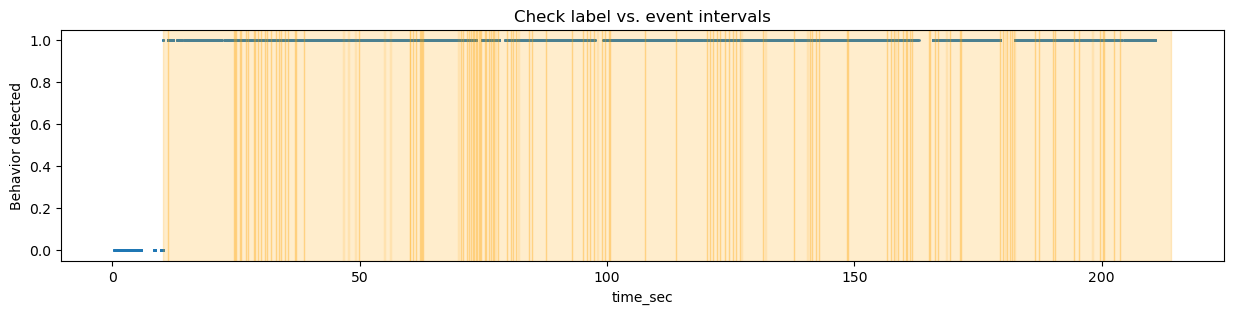

In [9]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [12]:
nan_counts = df_wide.isna().sum()

total_rows = len(df_wide)

nan_report = pd.DataFrame({
    'num_nan': nan_counts,
    'percent_nan': (nan_counts / total_rows) * 100
})

nan_report

,num_nan,percent_nan
frame,0,0.000000
time_sec,0,0.000000
hand,0,0.000000
hand_detected,0,0.000000
x_0,0,0.000000
...,...,...
z_17,0,0.000000
z_18,0,0.000000
z_19,0,0.000000
z_20,0,0.000000


In [13]:
df_wide_clean = df_wide.dropna()

df_wide_clean

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
377,618,10.300,Left,1,0.667783,0.624686,0.588127,0.555042,0.526116,0.620818,...,0.045121,0.045870,0.063222,0.065168,0.064045,0.058262,0.071685,0.077730,0.081355,lift
378,619,10.317,Left,1,0.667073,0.626269,0.590328,0.556585,0.526945,0.619462,...,0.045583,0.044985,0.061962,0.063077,0.061515,0.056215,0.069431,0.074755,0.077941,lift
379,620,10.333,Left,1,0.664240,0.619978,0.585626,0.553484,0.524581,0.617982,...,0.044138,0.045620,0.062612,0.065256,0.064862,0.057807,0.072158,0.078844,0.082631,lift
380,675,11.250,Left,1,0.707978,0.656801,0.627935,0.622260,0.616568,0.664836,...,-0.034240,-0.042123,-0.049831,-0.034310,-0.021720,-0.035604,-0.040010,-0.031016,-0.022704,lift
381,676,11.267,Left,1,0.714607,0.655401,0.621662,0.618785,0.621218,0.658802,...,-0.034551,-0.051444,-0.059443,-0.041615,-0.027574,-0.043814,-0.050422,-0.041019,-0.032236,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,12641,210.683,Left,1,0.646588,0.604351,0.574082,0.554245,0.540406,0.578712,...,-0.010203,-0.015333,-0.019103,-0.016046,-0.011553,-0.014998,-0.014997,-0.009999,-0.004630,other
12364,12642,210.700,Left,1,0.647436,0.606240,0.577767,0.557843,0.542924,0.579611,...,-0.010083,-0.013584,-0.018072,-0.016900,-0.013724,-0.013220,-0.014462,-0.011011,-0.006677,other
12365,12643,210.717,Left,1,0.634100,0.591933,0.557616,0.532277,0.511683,0.575248,...,0.002702,-0.001535,-0.002497,-0.003623,-0.002912,-0.001157,0.000147,0.002466,0.005062,other
12366,12644,210.733,Left,1,0.631710,0.588756,0.555392,0.531341,0.510141,0.569239,...,-0.012254,-0.011035,-0.015392,-0.015721,-0.014144,-0.008881,-0.010401,-0.007842,-0.004697,other


In [14]:
behavior_counts = df_wide_clean['behavior'].value_counts()

print(behavior_counts)

behavior
rotate    4650
hold      2331
press     2172
adjust    1992
other      821
place       15
lift        10
Name: count, dtype: int64


In [15]:
df_wide_clean['dataset_id'] = '01-test-02'

cols = df_wide_clean.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide_clean = df_wide_clean[cols]

df_wide_clean

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_2966/4059822352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide_clean['dataset_id'] = '01-test-02'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
377,01-test-02,618,10.300,Left,1,0.667783,0.624686,0.588127,0.555042,0.526116,...,0.045121,0.045870,0.063222,0.065168,0.064045,0.058262,0.071685,0.077730,0.081355,lift
378,01-test-02,619,10.317,Left,1,0.667073,0.626269,0.590328,0.556585,0.526945,...,0.045583,0.044985,0.061962,0.063077,0.061515,0.056215,0.069431,0.074755,0.077941,lift
379,01-test-02,620,10.333,Left,1,0.664240,0.619978,0.585626,0.553484,0.524581,...,0.044138,0.045620,0.062612,0.065256,0.064862,0.057807,0.072158,0.078844,0.082631,lift
380,01-test-02,675,11.250,Left,1,0.707978,0.656801,0.627935,0.622260,0.616568,...,-0.034240,-0.042123,-0.049831,-0.034310,-0.021720,-0.035604,-0.040010,-0.031016,-0.022704,lift
381,01-test-02,676,11.267,Left,1,0.714607,0.655401,0.621662,0.618785,0.621218,...,-0.034551,-0.051444,-0.059443,-0.041615,-0.027574,-0.043814,-0.050422,-0.041019,-0.032236,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,01-test-02,12641,210.683,Left,1,0.646588,0.604351,0.574082,0.554245,0.540406,...,-0.010203,-0.015333,-0.019103,-0.016046,-0.011553,-0.014998,-0.014997,-0.009999,-0.004630,other
12364,01-test-02,12642,210.700,Left,1,0.647436,0.606240,0.577767,0.557843,0.542924,...,-0.010083,-0.013584,-0.018072,-0.016900,-0.013724,-0.013220,-0.014462,-0.011011,-0.006677,other
12365,01-test-02,12643,210.717,Left,1,0.634100,0.591933,0.557616,0.532277,0.511683,...,0.002702,-0.001535,-0.002497,-0.003623,-0.002912,-0.001157,0.000147,0.002466,0.005062,other
12366,01-test-02,12644,210.733,Left,1,0.631710,0.588756,0.555392,0.531341,0.510141,...,-0.012254,-0.011035,-0.015392,-0.015721,-0.014144,-0.008881,-0.010401,-0.007842,-0.004697,other


In [17]:
df_wide_clean.to_csv("handlandmark_wide_01-test-02.csv", index=False)